# Election Monitor: Trump Reelection

## Automated Analysis of Corporate Perspectives on Trump's Presidential Re-election


## Why It Matters

Corporate executives' perspectives on presidential election outcomes significantly influence investment decisions, strategic planning, and market expectations, but systematically tracking these perspectives across thousands of earnings calls and corporate communications is challenging for investors and analysts. Understanding how businesses view potential policy changes under different administrations is crucial for identifying sector rotation opportunities, regulatory winners and losers, and companies with asymmetric exposure to political outcomes.

## What It Does

Using the functions available in the `bigdata-research-tools` package, you can create a comprehensive Election Monitor tool performing impact analysis of presidential elections. In the case of the US presidential elections, we used it to detect corporate positioning towards potential Republican administration policies using unstructured data from executive transcripts. These functions are suitable for analysts, portfolio managers, and investment professionals to create tools that transform scattered executive commentary into quantified political exposure metrics and identify investment opportunities based on corporate positioning analysis.

## How It Works

This workflow combines **metadata-enhanced semantic search**, **exposure classification**, and **network analysis** to deliver:

- **Positive vs. negative impact assessment** distinguishing companies that expect benefits from those anticipating challenges under Trump policies
- **Sector-wide political exposure mapping** revealing industry patterns in Trump administration positioning
- **Temporal exposure tracking** showing how political expectations evolve over time
- **Corporate-political topic networks** identifying key policy themes and company concerns through relationship analysis

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing corporate executives' perspectives on Trump's re-election using transcript data, showing how the system automatically identifies companies expecting positive outcomes (like financial firms benefiting from deregulation), those facing challenges (like renewable energy companies concerned about policy shifts), and reveals the underlying policy themes driving these expectations through automated positioning analysis and network visualization.

## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When `bigdata-research-tools` makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [3]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Below is the Python code required for setting up our environment and importing necessary libraries.

In [4]:
import pandas as pd

from src.tool import (
    plot_top_companies_by_sector,
    identify_basket_and_plot_confidence,
    transform_to_reference_format, 
    analyze_basket_with_labels
)
from src.search import search_by_any
from src.labeling import run_trump_reelection_prompt
from src.visualization_tools import obtain_company_topic_links, generate_networkx_network, generate_plotly_network_chart

from bigdata_client import Bigdata
from bigdata_client.models.search import DocumentType
from bigdata_research_tools.excel import ExcelManager

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [ ]:
import plotly.io as pio
import plotly.graph_objects as go

try:
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

interactive_plots = True  # Set to False to generate static plots

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our Trump reelection impact analysis results.

In [6]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/trump_reelection_impact_analysis.xlsx"

## Load Credentials

In [7]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [8]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining your Trump Reelection Impact Analysis Parameters


### Fixed Parameters
-  **Positive Impact Sentences** (`trump_positive_sentences_list`): Sentences used to identify companies expecting benefits from Trump reelection policies
-  **Negative Impact Sentences** (`trump_negative_sentences_list`): Sentences used to identify companies anticipating challenges from Trump administration
- **Election Context Sentences** (`election_related_sentences`): General election-related sentences to provide broader context
-  **Document Type** (`document_type`): Specify which documents to search over (transcripts, filings, news)


### Customizable Parameters
-  **Control Entities** (`control_entities`): Entities from Knowledge Graph to focus search on specific person, organization, or topic-related content
-  **Model Selection** (`llm_model`): The LLM model used to classify document chunks and generate analysis
-  **Frequency** (`search_frequency`): The frequency of the date ranges to search over.
   Supported values:

   -  `Y`: Yearly intervals.
   -  `M`: Monthly intervals.
   -  `W`: Weekly intervals.
   -  `D`: Daily intervals. Defaults to `M`.

-   **Time Period** (`start_date` and `end_date`): The date range over which to
   run the analysis

-  **Rerank Threshold** (`rerank_threshold`): By setting this value, you're
   enabling the cross-encoder which reranks the results and selects
   those whose relevance is above the percentile you specify (0.7 being
   the 70th percentile)

-  **Document Limit** (`document_limit`): The maximum number of documents to
   return per query to Bigdata API

-  **Batch Size** (`batch_size`): The number of entities to include in a
   single batched query

In [9]:
# ===== Fixed Parameters =====

# Sentences expressing positive Trump reelection impact
trump_positive_sentences_list = [
    "Donald Trump election will boost our business growth prospects",
    "Republican administration policies favor our industry sector expansion",
    "Trump presidency creates favorable regulatory environment for companies",
    "Corporate tax cuts under Trump administration benefit business operations",
    "Deregulation policies support our market expansion strategies effectively",
    "Trade policies under Republican leadership improve our competitive position",
    "Trump reelection provides stability for our business planning process",
    "Conservative economic policies align with our growth objectives perfectly",
    "Republican victory enhances our market opportunities and revenue potential",
    "Trump administration policies reduce compliance costs for our operations",
    "Pro-business Republican stance supports our expansion into new markets",
    "Lower corporate taxes under Trump improve our profit margins significantly",
    "Reduced government regulation under conservative leadership benefits our sector",
    "Trump trade negotiations create opportunities for our international business",
    "Republican economic agenda aligns with our strategic business goals",
    "Conservative fiscal policies support our investment and growth plans",
    "Trump presidency reduces regulatory burden on our business activities",
    "Pro-enterprise Republican policies enhance our competitive market advantage",
    "Deregulation under Trump administration improves our operational efficiency substantially",
    "Republican victory creates positive business climate for our industry",
    "Trump reelection supports our domestic manufacturing and job creation",
    "Conservative trade policies protect our market share from foreign competition",
    "Republican tax reform benefits our capital investment and expansion plans",
    "Trump administration energy policies reduce our operational costs significantly",
    "Pro-business Republican agenda supports our innovation and development initiatives"
]

# Sentences expressing negative Trump reelection impact
trump_negative_sentences_list = [
    "Trump election creates uncertainty for our business operations and planning",
    "Republican administration policies threaten our industry growth prospects significantly",
    "Trade war escalation under Trump hurts our international business relationships",
    "Trump presidency increases regulatory risks for our financial services",
    "Immigration restrictions under Republican leadership affect our workforce availability",
    "Trump reelection threatens our supply chain stability and costs",
    "Conservative social policies create reputational risks for our brand",
    "Republican victory endangers our environmental sustainability initiatives completely",
    "Trump administration policies increase compliance costs for our operations",
    "Trade tensions under Trump negatively impact our global market access",
    "Republican leadership threatens our diversity and inclusion business commitments",
    "Trump presidency creates geopolitical risks affecting our international operations",
    "Conservative economic policies threaten our government contract revenue streams",
    "Republican administration increases uncertainty for our healthcare business segment",
    "Trump reelection threatens our renewable energy and climate initiatives",
    "Immigration policies under Trump create labor shortage risks for operations",
    "Republican victory threatens our technology sector growth and innovation",
    "Trump trade policies increase costs for our international supply chain",
    "Conservative leadership threatens our ESG investing and sustainability goals",
    "Republican administration policies create regulatory uncertainty for our sector",
    "Trump presidency increases geopolitical tensions affecting our global business",
    "Trade protectionism under Trump hurts our export business opportunities",
    "Republican victory threatens our pharmaceutical and biotech research funding",
    "Trump administration policies increase cybersecurity and data privacy risks",
    "Conservative agenda threatens our clean technology and green energy investments"
]

# Election-related context sentences
election_related_sentences = [
    'U.S. presidential election results',
    'The outcome of the American presidential elections', 
    'U.S. presidential election results declared',
    'The U.S. presidential election results are official',
    'The final results of the U.S. presidential elections',
    'Outcome of the United States presidential vote',
    'Results of the U.S. presidential race announced'
]

# Document Configuration
document_type = DocumentType.TRANSCRIPTS

In [10]:
# ===== Customizable Parameters =====
# Trump Entity
trump_entity = bigdata.knowledge_graph.autosuggest(['Donald Trump'])['Donald Trump'][0]
control_entities = {'people': [trump_entity.id]}

# LLM Specification
llm_model = "openai::gpt-4o-mini"

# Search Frequency
search_frequency = 'M'

# Enable/Disable Reranker
rerank_threshold = None

# Specify Time Range
start_date = "2024-01-01"
end_date = "2024-06-30"

# Document Limits
document_limit = 1000

# Others
batch_size = 10

## Retrieve Content using Bigdata's Search Capabilities

With the Trump reelection impact narratives and analysis parameters, you can leverage the
Bigdata API to run an open discovery search on executive transcripts for both positive and negative Trump impact indicators.

In [11]:
# Combine all sentences for comprehensive search
all_sentences = trump_positive_sentences_list + trump_negative_sentences_list + election_related_sentences

search_results = search_by_any(
    sentences=all_sentences,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    control_entities=control_entities,
    freq=search_frequency,
    document_limit=document_limit,
)

Processing transcripts results...: 100%|██████████| 2178/2178 [00:00<00:00, 87571.48it/s]


## Label the Results

Use an LLM to analyze each document chunk and determine whether it represents positive, negative, or unclear positioning toward Trump reelection impact on the company's business.

In [12]:
search_results_renamed = search_results.rename(columns={
    'entity_id': 'rp_entity_id',
    'document_id': 'rp_document_id',
})

labeled_results_custom = run_trump_reelection_prompt(
    sentences=search_results_renamed,
    sentence_column_2='masked_text',
    masked_2=True,
    n_expected_response_tokens=100,
    batch_size=10,
    model="gpt-4o-mini",
    open_ai_credentials=OPENAI_API_KEY
)

custom_counts = labeled_results_custom['label'].value_counts()
print(f"🔢 Results: {custom_counts.get('P', 0)} positive, {custom_counts.get('N', 0)} negative, {custom_counts.get('U', 0)} unclear")

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:18<00:00,  1.35it/s]

🔢 Results: 25 positive, 26 negative, 191 unclear


In [13]:
df_all_labeled_transform = transform_to_reference_format(labeled_results_custom)
df_positive = df_all_labeled_transform[df_all_labeled_transform["label"] == "P"].copy()
df_positive.reset_index(drop=True, inplace=True)
df_negative = df_all_labeled_transform[df_all_labeled_transform["label"] == "N"].copy()
df_negative.reset_index(drop=True, inplace=True)

## Visualizations

## Sector-Based Trump Impact Visualization

The following visualizations provide a sector-by-sector breakdown of companies mentioned in Trump reelection impact contexts. These charts help identify:

- **Industry Patterns**: Which sectors show more positive vs negative exposure to Trump policies
- **Political Exposure Leaders**: Companies most frequently mentioned in Trump impact contexts within each sector  
- **Policy Context**: Detailed hover information reveals the specific headlines, motivations, and transcript excerpts driving each company's positioning

Each bar represents the frequency of Trump impact mentions, with hover details providing the underlying executive commentary that shaped each company's political exposure profile.

### Companies Expecting Positive Trump Impact

This chart displays companies that have been most frequently mentioned in positive Trump reelection contexts, organized by sector and ranked by total mention volume. The visualization reveals which companies and industries expect to benefit from Republican administration policies.

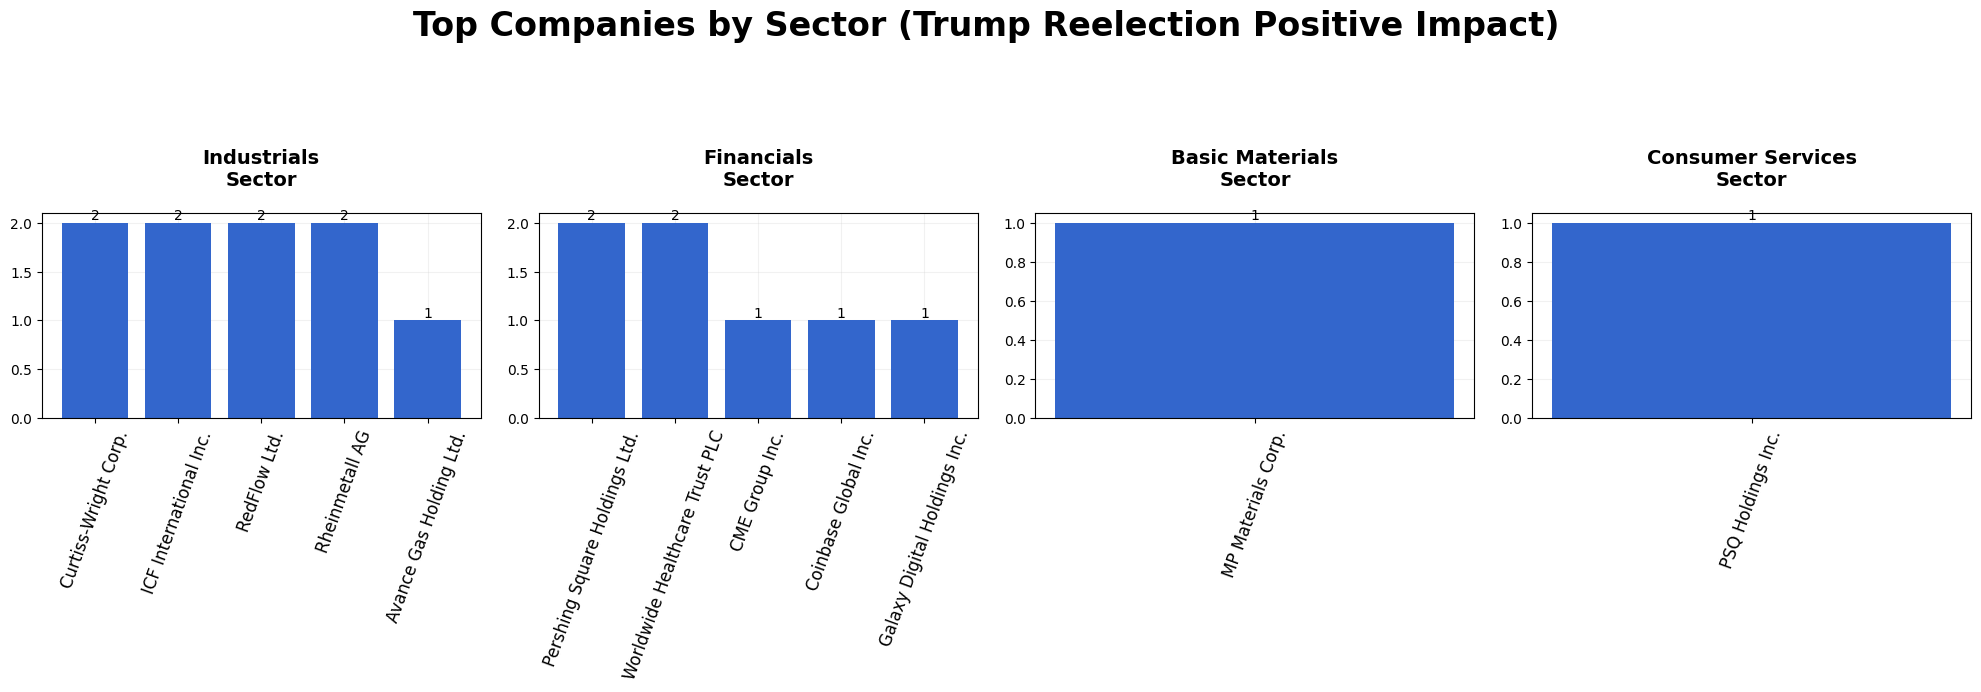

In [22]:
plot_top_companies_by_sector(df_positive, min_companies=1, title_suffix="(Trump Reelection Positive Impact)", top_sectors=4, interactive=interactive_plots)

### Companies Expecting Negative Trump Impact

This complementary chart shows companies most frequently mentioned in negative Trump reelection contexts, organized by sector and ranked by total mention volume. It identifies firms that anticipate challenges from Trump administration policies.

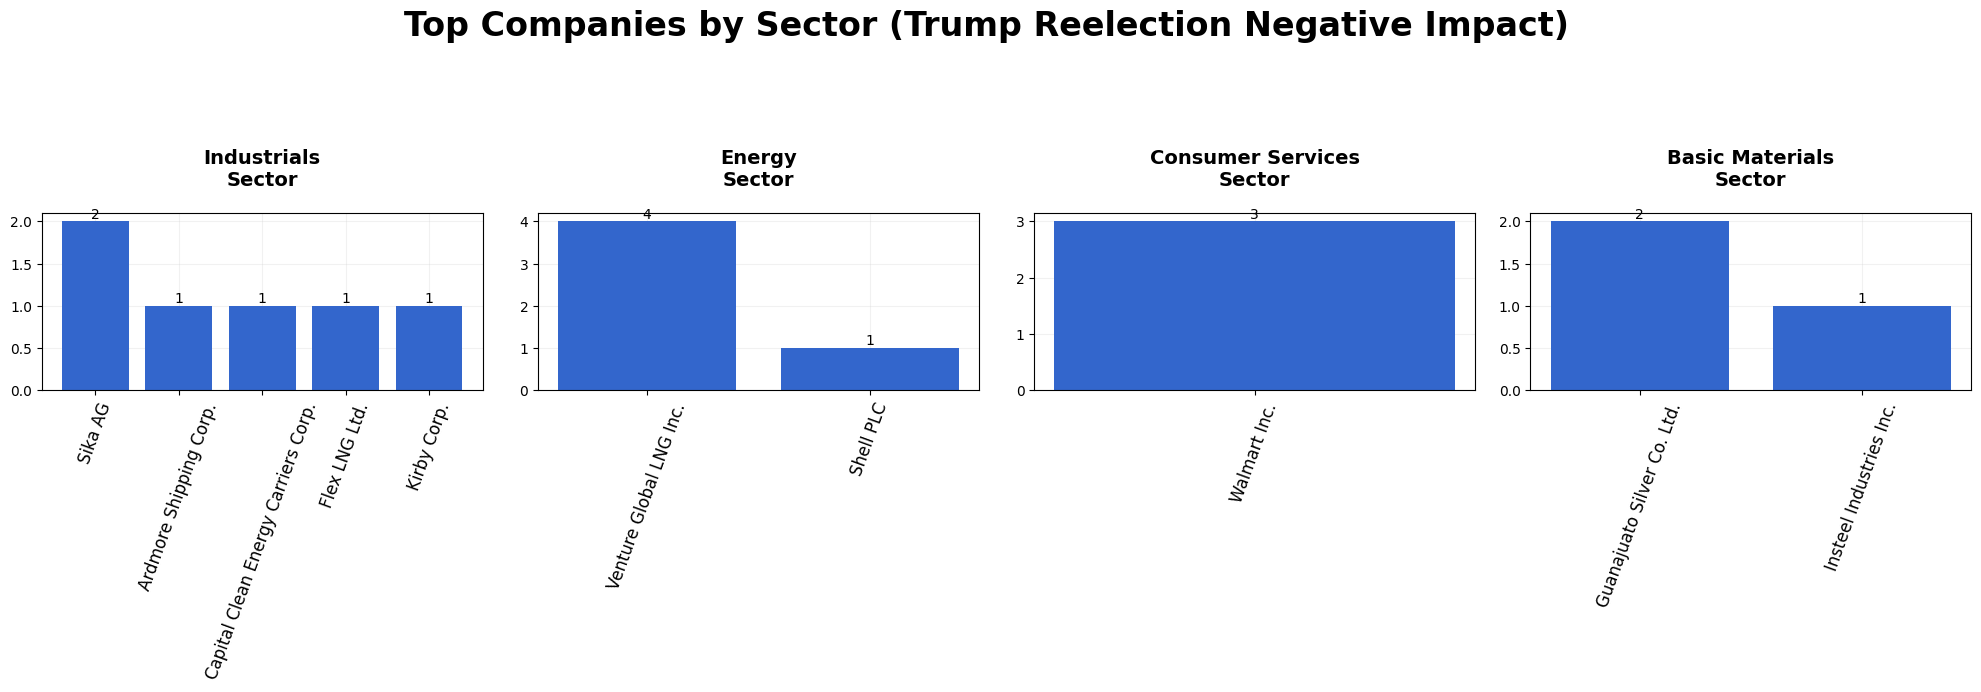

In [23]:
plot_top_companies_by_sector(df_negative, min_companies=1, title_suffix="(Trump Reelection Negative Impact)", top_sectors=4, interactive=interactive_plots)

## Trump Reelection Impact Confidence Analysis

This comprehensive assessment combines both positive and negative Trump impact signals to create a confidence-based ranking system. The analysis provides:

- **Total Exposure**: Overall volume of Trump impact related executive commentary for each company
- **Confidence Scoring**: Relative proportion of positive versus negative Trump impact mentions  
- **Political Positioning**: How companies compare against each other in terms of their expected Trump impact exposure

The stacked bar chart shows the percentage breakdown of positive (green) versus negative (red) Trump impact mentions for the top companies. Companies to the right show predominantly positive expectations from Trump policies, while those to the left expect more challenges. The visualization helps identify companies with the strongest political exposure to Trump administration outcomes.

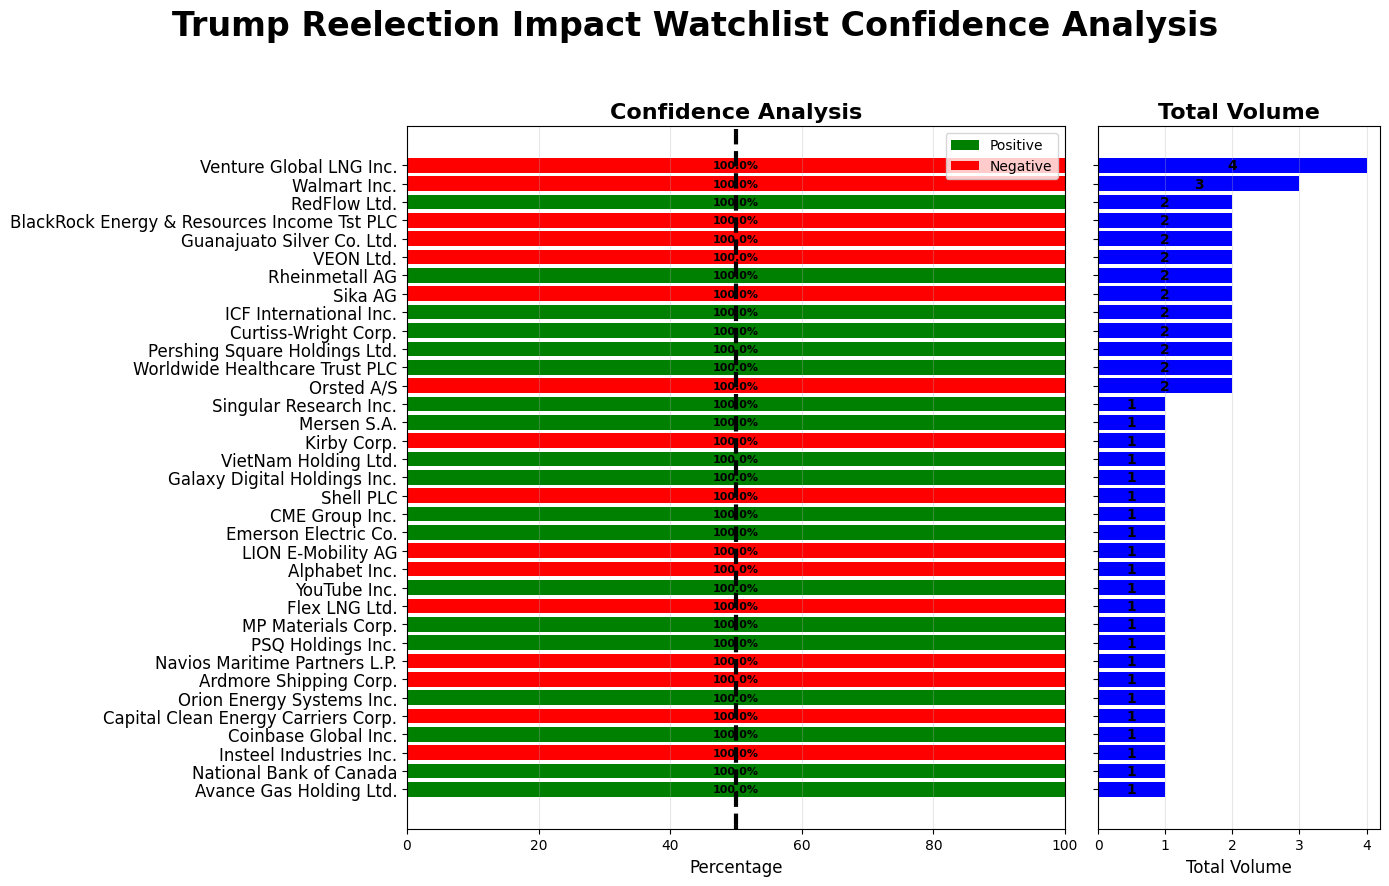

In [24]:
companies_basket = identify_basket_and_plot_confidence(df_positive, df_negative, basket_size=40, theme_name='Trump Reelection Impact', positive_label='Positive', negative_label='Negative', interactive=interactive_plots)

## Temporal Trump Impact Analysis

This time-series analysis tracks how Trump reelection impact narratives evolve over time for companies in our basket. The weekly analysis reveals:

- **Political Exposure Trends**: How Trump impact expectations develop and change over time leading up to elections
- **Net Political Positioning**: The balance between positive and negative Trump impact mentions over time

Each line represents a company's "net Trump impact exposure" (positive mentions minus negative mentions). Points above zero indicate weeks with net positive Trump impact signals, while points below zero show weeks with net negative expectations. Detailed hover information provides the specific executive commentary context driving each data point.

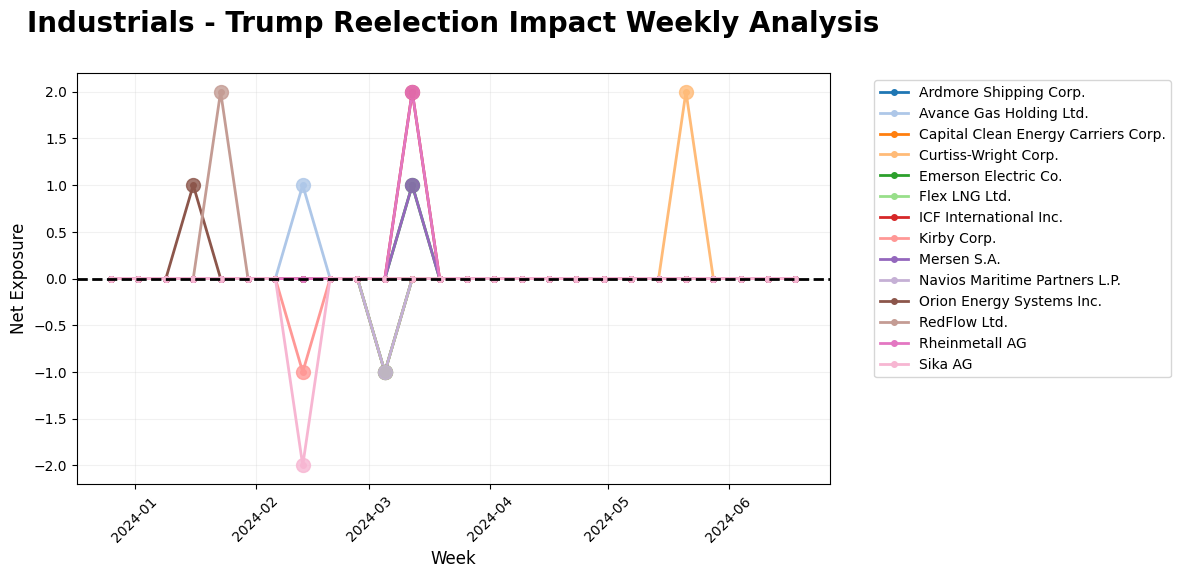

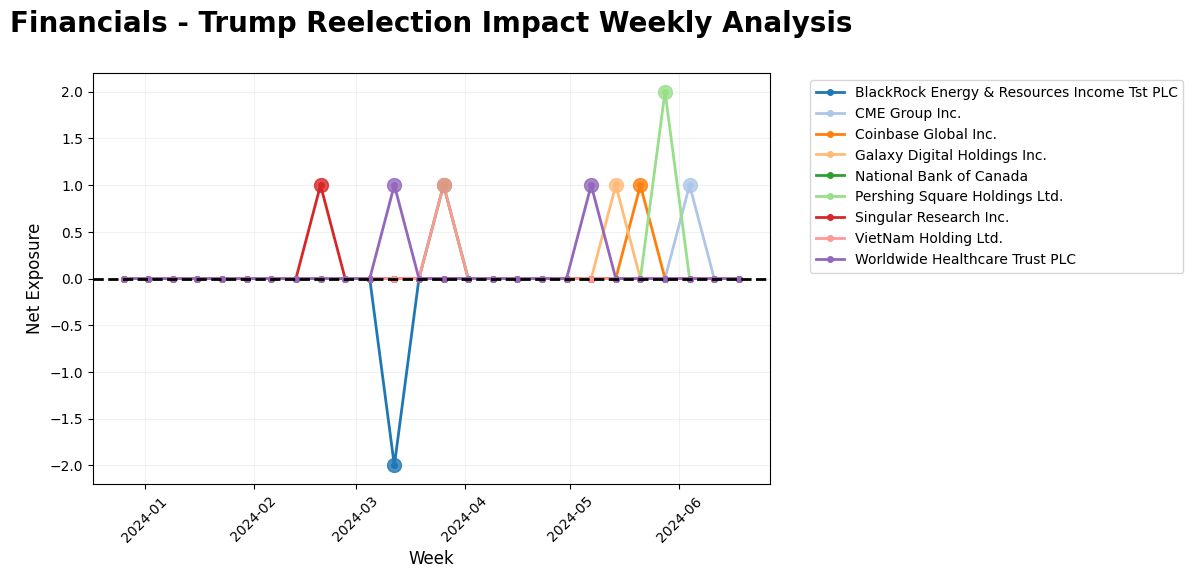

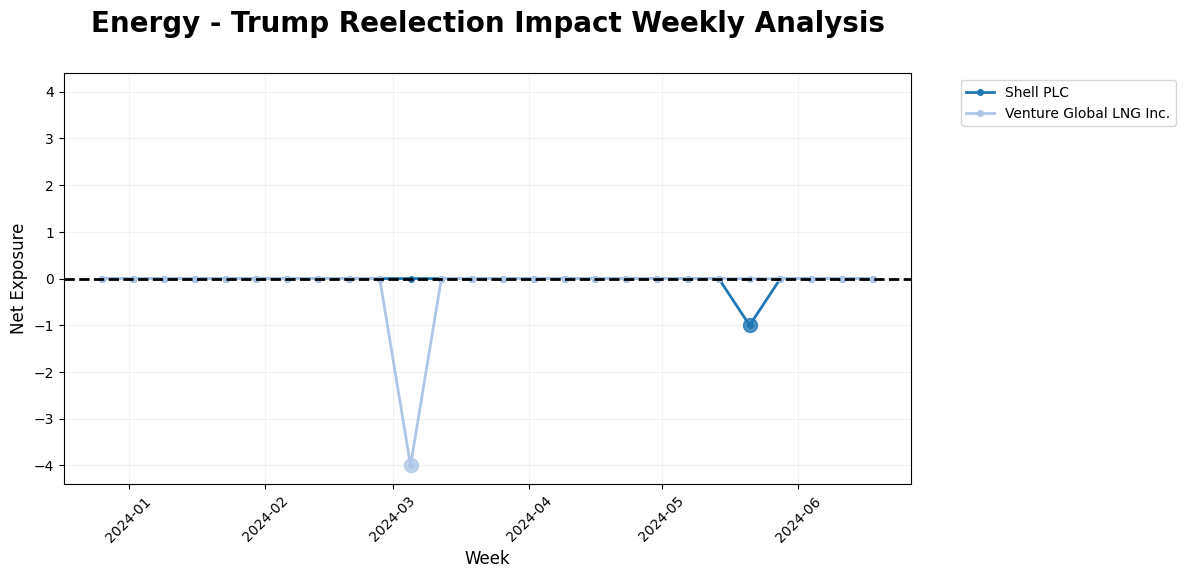

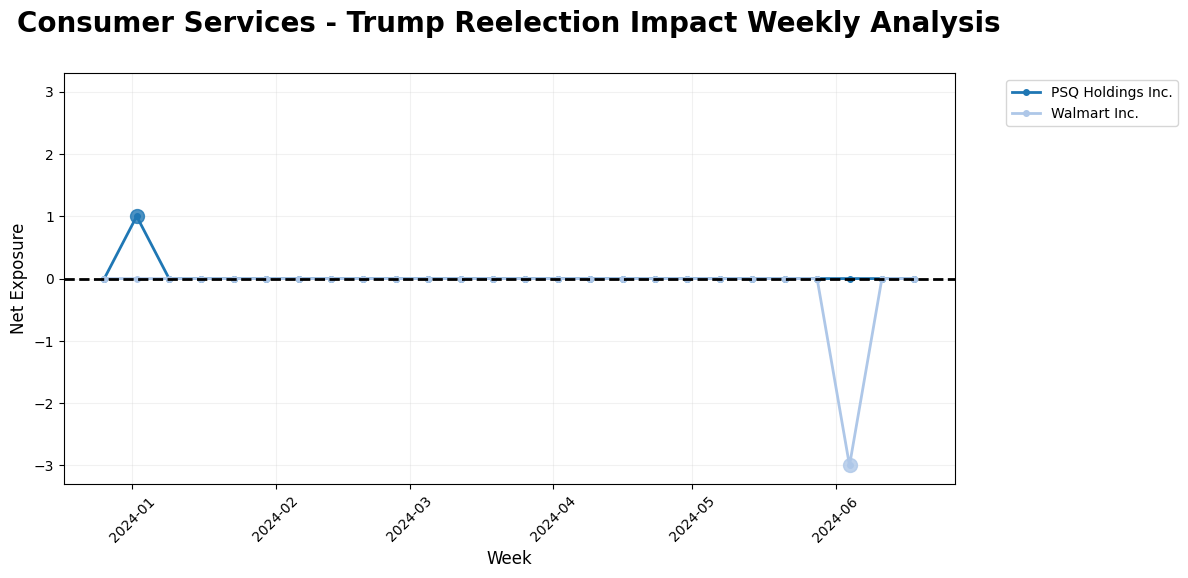

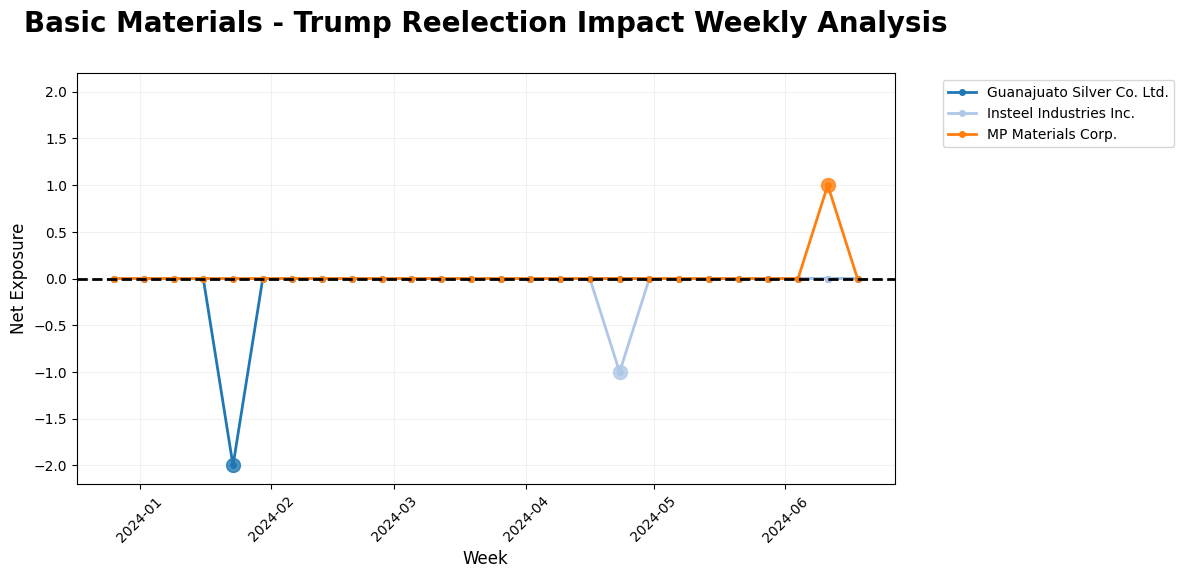

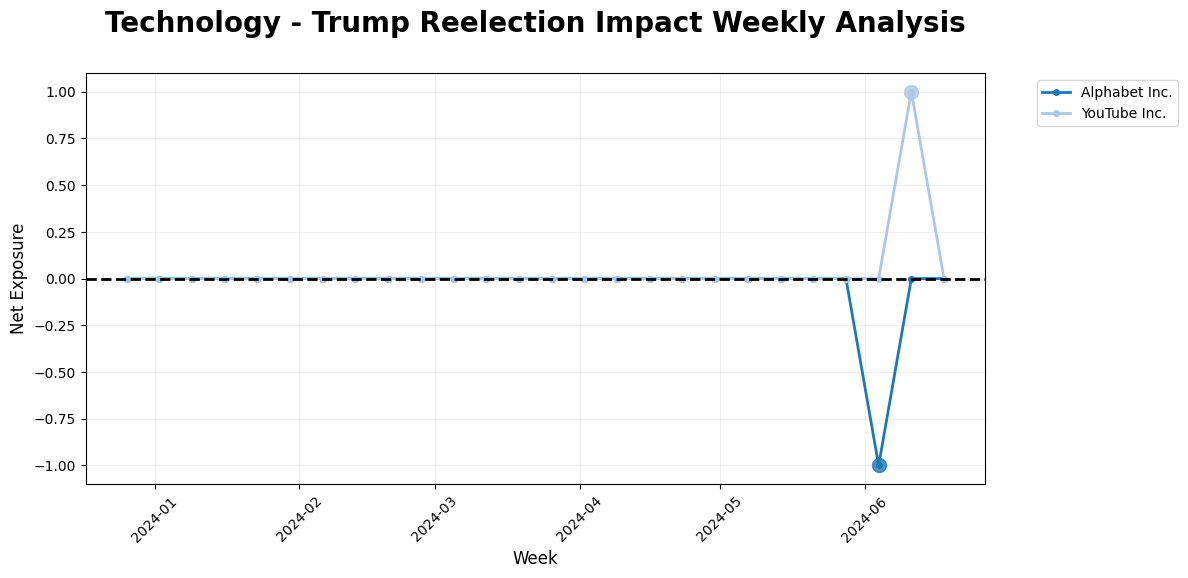

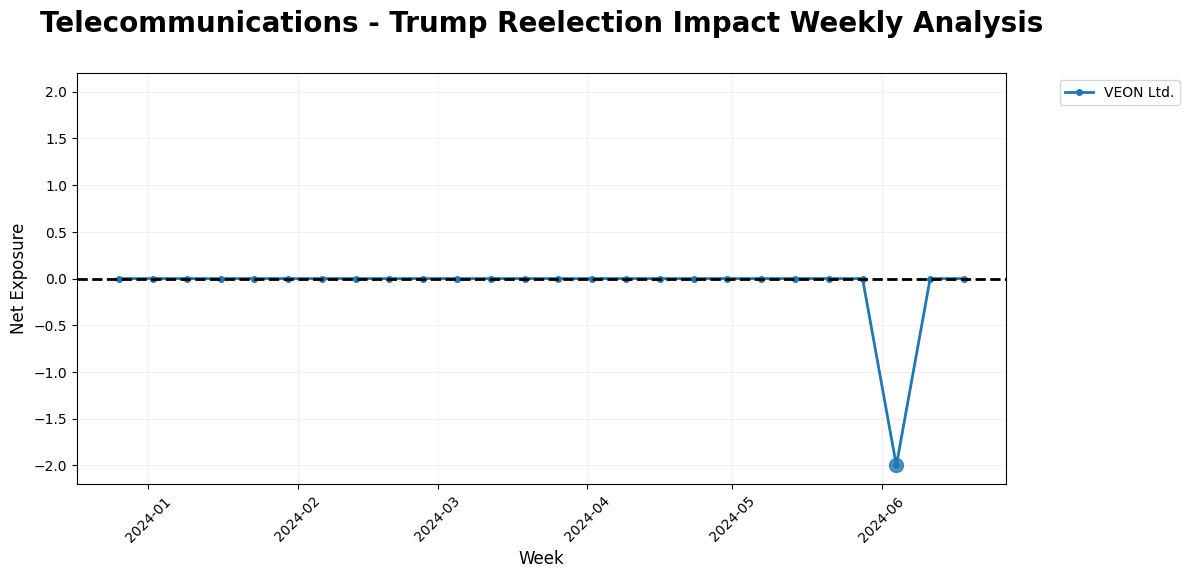

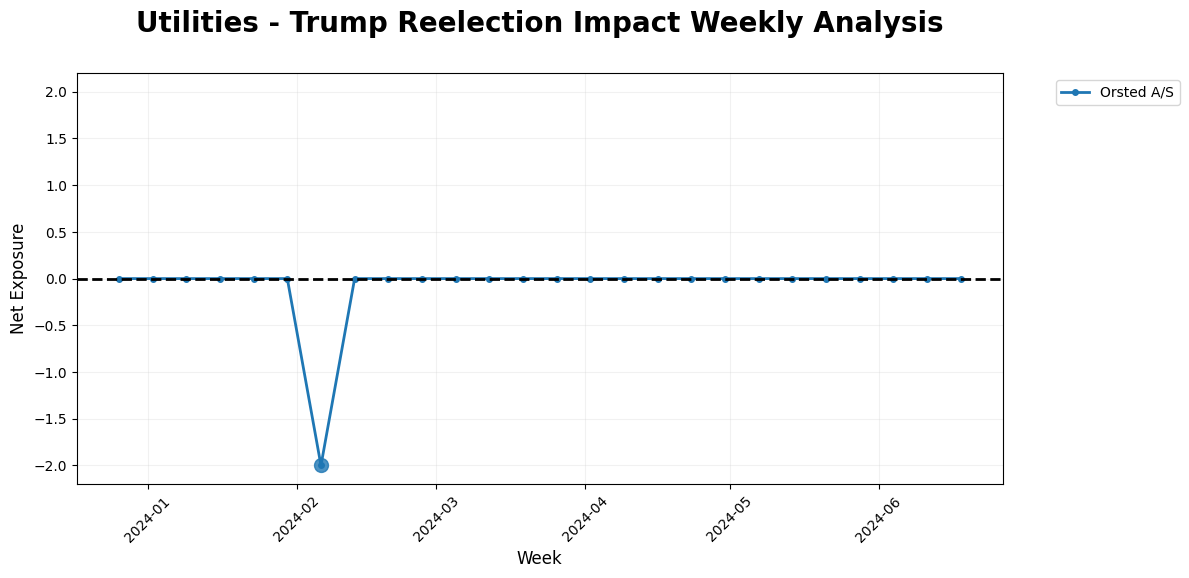

In [25]:
weekly_exposure = analyze_basket_with_labels(
    df_positive, 
    df_negative, 
    companies_basket, 
    start_date, 
    end_date, 
    'Sector',
    theme_name='Trump Reelection Impact',
    interactive=interactive_plots,
    frequency='weekly',
    analysis_suffix = "Weekly Analysis"
)

## Corporate-Political Topic Network Analysis

This network visualization reveals relationships between companies and topics through co-mentions in executive transcripts. The analysis identifies:

- **Policy Theme Clusters**: Companies that frequently discuss similar Trump administration policy themes
- **Political Exposure Networks**: Connections between companies and specific political topics like trade, regulation, or taxation
- **Sectoral Policy Patterns**: Groups of companies from similar industries discussing common Trump impact themes

The network helps identify which specific topics are most important to different companies and reveals how companies cluster around common political concerns or opportunities related to Trump reelection.

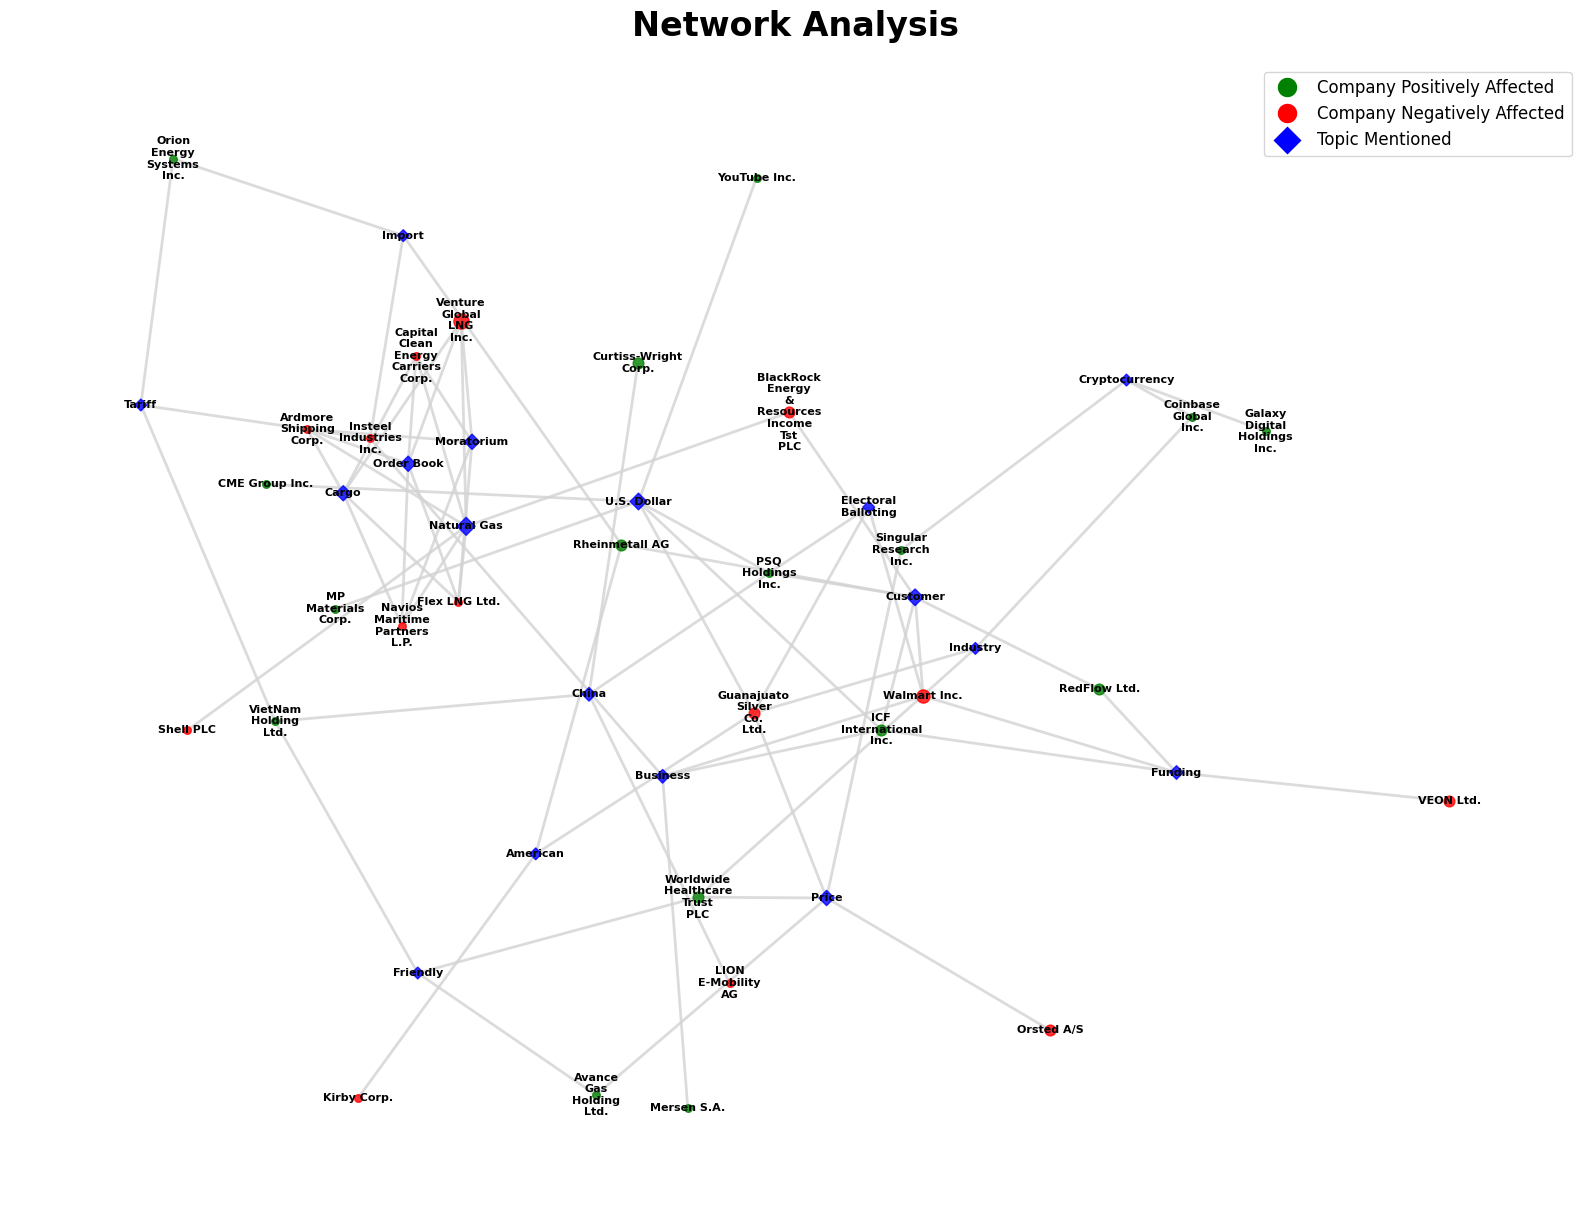

In [26]:
df_count, entity_sizes, topic_sizes, entity_colors, topic_colors = obtain_company_topic_links(
    df_all_labeled_transform,
    ['P','N'], 
    ['Donald Trump','United States of America','Joe Biden','U.S. Republican Party','U.S. Democratic Party','Government of the United States','Politics'], 
    bigdata
)
G = generate_networkx_network(df_count, entity_sizes, topic_sizes, entity_colors, topic_colors)
generate_plotly_network_chart(G, ['Company Positively Affected', 'Company Negatively Affected', 'Topic Mentioned'], interactive=interactive_plots)

## Key Insights and Sectoral Patterns

The Trump reelection impact analysis reveals clear sectoral patterns in corporate positioning:

**Financial Sector Optimism**: Financial companies consistently show positive positioning toward Trump reelection, anticipating benefits from potential deregulation policies, reduced compliance requirements, and pro-business tax reforms that could improve their operational efficiency and profitability.

**Mixed Industrial Responses**: Industrial companies show varied responses to Trump policies, with some expecting benefits from domestic manufacturing initiatives and trade protection, while others express concerns about trade war impacts on their supply chains and international operations.

**Energy Sector Division**: The energy sector demonstrates polarized positioning, reflecting different business models and policy exposures, with traditional energy companies often expecting positive impacts from reduced environmental regulations, while renewable energy companies express concerns about potential policy shifts away from clean energy support.

**Basic Materials Concerns**: The sector shows predominantly negative outlook, with companies expressing concerns about trade war impacts and supply chain disruptions.

**Notable Negative Positioning Examples**: Several major companies across different sectors express significant concerns about Trump policies:
- **Ørsted A/S**: Expresses concern about Trump's negative stance on offshore wind, potential risks to federal permits, and negative impacts from another Trump administration
- **BYD**: Discusses potential negative impact of Trump's policies on EV demand and electric vehicle market dynamics
- **Walmart Inc.**: Expresses strong negative views on Trump and associates, indicating threats to business stability and concerns about impacts on the system of government and business



**Policy Theme Dominance**: Beyond politics, the most interesting topic themes emerging from the analysis include U.S. Dollar impacts (currency and monetary policy implications), China relations (trade tensions and bilateral business effects), and Natural Gas (energy policy and regulatory changes), indicating these are the primary areas where executives expect the most significant business impacts from Trump policies.

These patterns reflect the heterogeneous nature of Trump policy impacts across different industries, with clear winners and losers based on each sector's alignment with Republican policy priorities and their exposure to international trade dynamics.

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [19]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_positive, "Trump Positive Impact", (0, 0)),
        (df_negative, "Trump Negative Impact", (0, 0)),
        (companies_basket, "Trump Impact Basket", (2, 4)),
        (weekly_exposure, "Weekly Exposure Analysis", (2, 2))
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)
    print(f"✅ Results exported to {export_path}")

except Exception as e:
        print(f"Warning while exporting to excel: {e}")


✅ Results exported to output/trump_reelection_impact_analysis.xlsx


In [20]:
print("Runtime:", datetime.datetime.now() - start)

Runtime: 0:01:42.475198
